# Homework 3: Problems 4, 5 and Extra Credit 2

In this notebook, we will begin to use QuTiP, a helpful Python package for simulating the dynamics of quantum systems. Make sure you have QuTiP already configured on your computer before running this notebook. Helpful examples (including instructions on installing QuTiP) can be found at http://qutip.org/tutorials.html.

1. How to handle time evolution with a master equation: https://qutip.org/docs/latest/guide/dynamics/dynamics-master.html
2. How to plot on the Bloch sphere: https://qutip.org/docs/latest/guide/guide-bloch.html

In [23]:
# First we must import relevant packages
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

# Define twopi to reduce clutter
twopi = 2 * np.pi

## Problem 2
## 2e

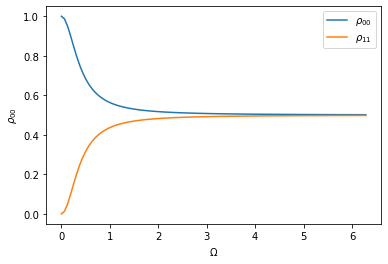

In [24]:
# Choose values for delta and gamma
delta, gamma = 0.5, 0.4

# Define R_opt
def R_opt(omega):
    return gamma * (omega**2) / ((gamma / 2)**2 + delta**2)

# Obtained value for rho_00
def rho_00(omega):
    return (gamma + R_opt(omega)) / (gamma + 2 * R_opt(omega))

# Obtained value for rho_11
def rho_11(omega):
    return R_opt(omega) / (gamma + 2 * R_opt(omega))

# Plot the values for different omega
f = lambda x: rho_00(x)
g = lambda x : rho_11(x)
omegaa = np.linspace(0, 1, 100) * twopi
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\rho_{00}$')
plt.plot(omegaa, f(omegaa))
plt.plot(omegaa, g(omegaa))
plt.legend([r'$\rho_{00}$', r'$\rho_{11}$'])
plt.show()

<font color="blue" size="4">
    $$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
    This plot does agree with what we obtained previously for the following reasons.
    <ol>
        <li> In the limit $\Omega \to 0$, that is $R_{\text{opt}} \ll \gamma$ we have that $\rho_{00} \to 1$ and $\rho_{11} \to 0$, as we derived. </li>
        <li> In the limit $\Omega \gg \gamma$, that is $R_{\text{opt}} \gg \gamma$ we have that $\rho_{00} \to 1/2$ and $\rho_{11} \to 1/2$, as we derived. </li>
        <li> As $\Omega$ increases, which means that $R_{\text{opt}}$ increases, both $\rho_{00}$ and $\rho_{11}$ approach $1/2$, as we expect because the dominant dynamical effect is that produced by $R_{\text{opt}}$ and the $\gamma$ decay becomes negligible, and so the state becomes more and more mixed as $R_{\text{opt}}$ transfers the population both from $\ket 1 \to \ket 0$ and $\ket 0 \to \ket 1.$ </li>
    </ol>
</font>

***
## Problem 4
## 4a

Below, we have solved the master equation for a single qubit under a coherent drive $\Omega$ with detuning from resonance $\Delta$, subject to spontaneous emission at a rate $\gamma$. By examining and running the cells below you will see how to encode the parameters of the master equation, and display the results in a helpful manner.

In [25]:
def solve_me(delta, omega, gamma, time=10):
    """ Solves a single-qubit master equation
    
    See HW3 for details on the Hamiltonian
    :param delta: Detuning (units of 1/time)
    :param omega: Rabi frequency (units of 1/time)
    :param gamma: Spontaneous emission rate (units of 1/time)
    :param time: (opt) time to run until
    """
    
    # Define the Hamiltonian
    H = delta * sigmaz() + omega * sigmax()
    
    # Collapse (Lindblad) operators
    #
    # NOTE: we use sigmap() here because this performs
    # the desired |0><1| operation mapping state |1>
    # onto state |0>
    #
    c_ops = [np.sqrt(gamma) * sigmap()]
    
    # Operators to measure
    m_ops = [sigmax(), sigmay(), sigmaz()]
    
    # Initial state
    psi_0 = basis(2,0) #This should be read as out of 2 basis state {|0>, |1>}, select |0>
    
    # Time steps to measure on
    time = np.linspace(0, time, 1000)
    
    # Solve master equation
    solution = mesolve(H, psi_0, time, c_ops, m_ops)
    
    return solution.expect

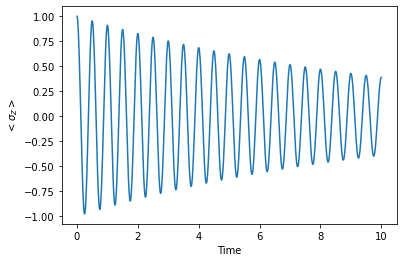

In [26]:
# Parameters
delta, omega, gamma = 0, twopi, 0.02 * twopi

# Time to plot for
time = 10

# Plot the dynamics (<sigma_z>)
# You can also plot <sigma_x>, <sigma_y> using result[0], result[1]
result_4a = solve_me(delta, omega, gamma, time=time)
time_axis = np.linspace(0, time, 1000)
plt.xlabel('Time')
plt.ylabel('$<\sigma_Z>$')
plt.plot(time_axis, result_4a[2])
plt.show()

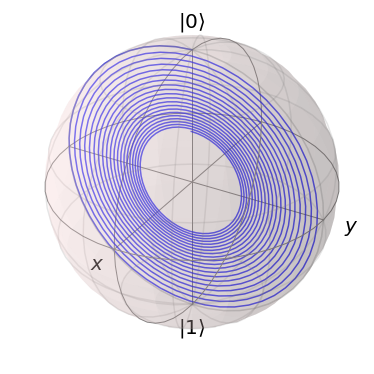

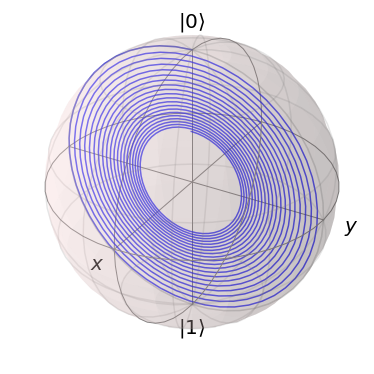

In [27]:
# Display trajectory on the Bloch sphere
bloch_sphere = Bloch()
bloch_sphere.add_points([result_4a[0], result_4a[1], result_4a[2]], meth='l')
bloch_sphere.show()

<font color="blue" size="4">
    We can see that this case corresponds to the regime where $R_{\text{opt}} \gg \gamma,$ since the Bloch vector is slowly approaching the origin and therefore the state is becoming more mixed with time. That is, $$\vec r \to \vec 0 \quad \text{as} \quad t \to \infty.$$
</font>

## 4b

Here we can use scipy.integrate.odeint to directly integrate the rate equations. Since we already have an expression for $\langle \sigma_z \rangle (t)$ from our master equation solver, we can use the relation $\langle \sigma_z \rangle (t) = \rho_{00}(t) - \rho_{11}(t)$ to derive the relevant rate equation: $$\frac{d \langle \sigma_z \rangle}{d t} = - (\gamma + 2 R) \langle \sigma_z \rangle + \gamma$$

In [28]:
from scipy.integrate import odeint

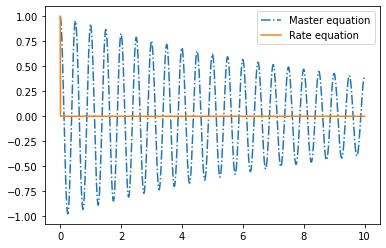

In [29]:
# Pumping rate
r = gamma * omega**2 / (gamma**2/4 + delta**2)

# d<sigma_z>/dt function
def dsdt(s,t):
    return -(gamma+2*r)*s + gamma

# Initial condition
s_0 = 1

# Solve and overlay with master equation solution
s_t = odeint(dsdt, s_0, time_axis)
plt.plot(time_axis, result_4a[2], '-.')
plt.plot(time_axis, s_t)
plt.legend(['Master equation', 'Rate equation'])
plt.show()

<font color="blue" size="4">
    We can see a big disagreement between the result obtained through the master equation and that of the rate equation. This is due to the fact that the rate equation assumes that the system evolves purely incoherently, that is, $\dot \rho_{01} = 0.$ However, we derived in problem 2a that the evolution of $\rho_{01}$ is given by, using $\Delta = 0$ and the fact that $\Omega$ is real $$\dot \rho_{01} = -\frac{\gamma}{2}\rho_{01} + i\Omega(\rho_{00} - \rho_{11}).$$ And in our case we could ignore $\gamma$ since $\gamma \ll \Omega$ but we can certainly not ignore $\Omega$ in this equation, which means that $\dot \rho_{01} \not = 0$ and the rate equations derived in problem 2c do not apply in this situation. Therefore, the dominant contribution to the evolution of $\rho_{01}$ is given by the $i\Omega$ term, which gives us the oscillation seen in the master equation approach, modulated by the (relatively slow) exponential decay given by $\gamma.$
</font>

## 4c

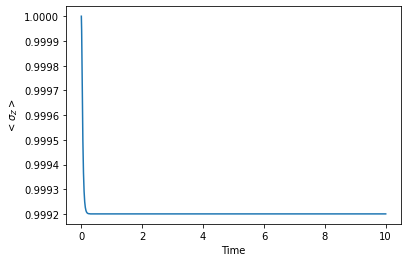

In [30]:
# Resolve master equation with new parameters, plot <sigma_z>
# Parameters given
delta, omega, gamma = 0, 0.1 * twopi, 10 * twopi

# Time to plot for
time = 10

# Solve master equation and plot
result_4c = solve_me(delta, omega, gamma, time=time)
time_axis = np.linspace(0, time, 1000)
plt.xlabel('Time')
plt.ylabel('$<\sigma_Z>$')
plt.plot(time_axis, result_4c[2])
plt.show()

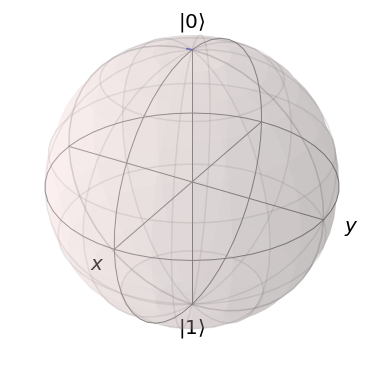

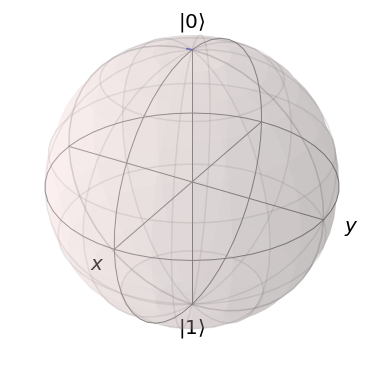

In [31]:
# Display trajectory on the Bloch sphere
bloch_sphere = Bloch()
bloch_sphere.add_points([result_4c[0], result_4c[1], result_4c[2]], meth='l')
bloch_sphere.show()

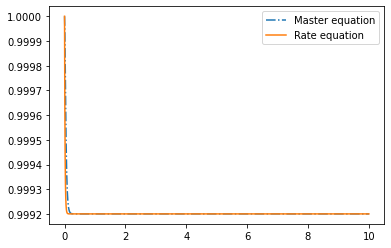

In [32]:
# Resolve rate equation and overlay plots
time_axis = np.linspace(0, time, 1000)
r = gamma * omega**2 / (gamma**2/4 + delta**2)
# d<sigma_z>/dt function
def dsdt(s,t):
    return -(gamma + 2 * r) * s + gamma
s_0 = 1
s_t = odeint(dsdt, s_0, time_axis)

# Plot both approaches
plt.plot(time_axis, result_4c[2], '-.')
plt.plot(time_axis, s_t)
plt.legend(['Master equation', 'Rate equation'])
plt.show()

<font color="blue" size="4">
    We can see from the above that $\langle\sigma_z\rangle$ stays at 1 in this case. It will be easier to see this if we rescale the $y$ axis. This is shown below.
</font>

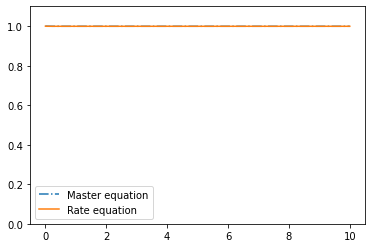

In [33]:
# Resolve rate equation and overlay plots
time_axis = np.linspace(0, time, 1000)
r = gamma * omega**2 / (gamma**2/4 + delta**2)
# d<sigma_z>/dt function
def dsdt(s,t):
    return -(gamma + 2 * r) * s + gamma
s_0 = 1
s_t = odeint(dsdt, s_0, time_axis)

# Plot both approaches
plt.plot(time_axis, result_4c[2], '-.')
plt.plot(time_axis, s_t)
plt.ylim((0,1.1))
plt.legend(['Master equation', 'Rate equation'])
plt.show()

<font color="blue" size="4">
    $$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
    First note that with the given values of $\Omega$ and $\gamma$ we can quickly see that we are in the regime $R_{\text{opt}} \ll \gamma.$ Therefore, the dominant contribution to the evolution of $\rho_{01}$ is the decay term given by $\gamma/2.$ Now, we know that $\rho_{01}$ starts at $\rho_{01} = 0.$ As time goes on, $\rho_{01}$ is going to oscillate somewhat because of the $i\Omega$ term in its evolution, which corresponds to oscillation, but this oscillation will be supressed by the dominant decay. Therefore, we can safely assume that $\rho_{01}$ is simply going to remain at $0$ as the system evolves, meaning that the assumption made for deriving the rate equations, $\dot \rho_{01} = 0$ is indeed valid in this case. Finally, since $R_{\text{opt}} \ll \gamma,$ we expect the dynamics of the qubit to be dominated by decay from $\ket 1 \to \ket 0,$ with the steady-state limit of the qubit being $\ket 0,$ which corresponds to $\langle\sigma_z\rangle = 1,$ as we indeed see above!
    <br>
    This is also clearly seen in the Bloch sphere trajectory, with the trajectory essentially staying at (or really close to) $\ket 0$ all the time.
</font>

## 4d

In [43]:
# Modified master equation with pure dephasing operator
def solve_me_d(delta, omega, gamma, gamma_d, time=10):
    # Define the Hamiltonian
    H = delta * sigmaz() + omega * sigmax()
    
    # Collapse (Lindblad) operators
    #
    # NOTE: we use sigmap() here because this performs
    # the desired |0><1| operation mapping state |1>
    # onto state |0>
    
    # Here we add the L_d dephasing operator to the list
    c_ops = [np.sqrt(gamma) * sigmap(), np.sqrt(gamma_d) * sigmaz()]
    
    # Operators to measure
    m_ops = [sigmax(), sigmay(), sigmaz()]
    
    # Initial state
    psi_0 = basis(2,0) #This should be read as out of 2 basis state {|0>, |1>}, select |0>
    
    # Time steps to measure on
    time = np.linspace(0, time, 1000)
    
    # Solve master equation
    solution = mesolve(H, psi_0, time, c_ops, m_ops)
    
    return solution.expect

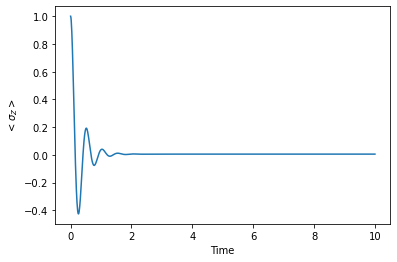

In [35]:
# Solve master equation and display trajectory on the Bloch sphere
# Parameters given
delta, omega, gamma, gamma_d = 0, twopi, 0.02 * twopi, 0.5 * twopi

# Time to plot for
time = 10

# Solve master equation and plot
result_4d = solve_me_d(delta, omega, gamma, gamma_d, time=time)
time_axis = np.linspace(0, time, 1000)
plt.xlabel('Time')
plt.ylabel('$<\sigma_Z>$')
plt.plot(time_axis, result_4d[2])
plt.show()

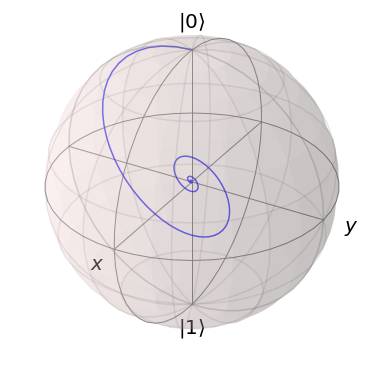

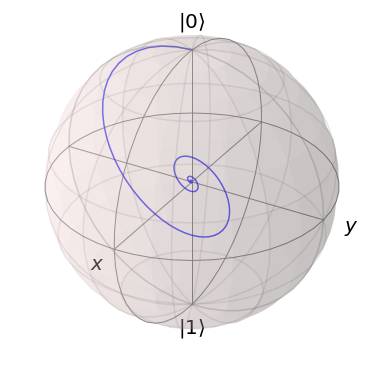

In [36]:
# Display trajectory on the Bloch sphere
bloch_sphere = Bloch()
bloch_sphere.add_points([result_4d[0], result_4d[1], result_4d[2]], meth='l')
bloch_sphere.show()

<font color="blue" size="4">
    To compare this with our results from problem 4a, let us plot $\langle\sigma_z\rangle$ for both cases.
</font>

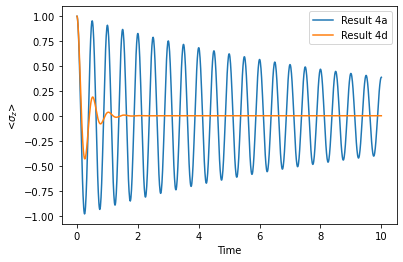

In [37]:
time = 10
time_axis = np.linspace(0, time, 1000)
plt.xlabel('Time')
plt.ylabel(r'<$\sigma_z$>')
plt.plot(time_axis, result_4a[2])
plt.plot(time_axis, result_4d[2])
plt.legend(['Result 4a', 'Result 4d'])
plt.show()

<font color="blue" size="4">
    We can immediately observe that the effect of the dephasing operator $L_d$ is to cause a greater decay of the Bloch vector, that is, with the dephasing parameter the Bloch vector will approach the origin faster. There is still some oscillation in the case of the dephasing operator but the dominant effect is exponential decay.
</font>

***
## Problem 5
## 5a

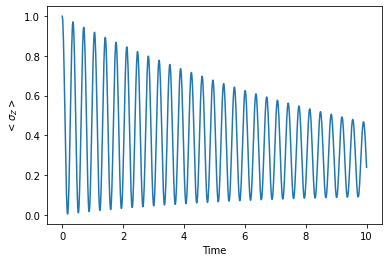

In [38]:
# Solve master equation and display trajectory on the Bloch sphere
# Parameters given
delta, omega, gamma, gamma_d = twopi, twopi, 0.001 * twopi, 0.01 * twopi

# Time to plot for
time = 10

# Solve master equation and plot
result_5a = solve_me_d(delta, omega, gamma, gamma_d, time=time)
time_axis = np.linspace(0, time, 1000)
plt.xlabel('Time')
plt.ylabel('$<\sigma_Z>$')
plt.plot(time_axis, result_5a[2])
plt.show()

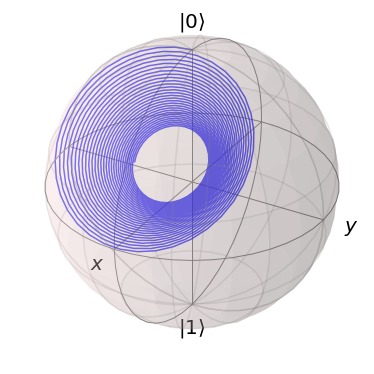

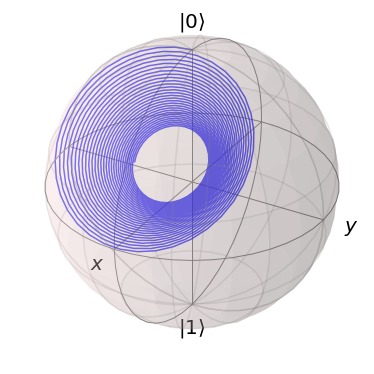

In [39]:
# Display trajectory on the Bloch sphere
bloch_sphere = Bloch()
bloch_sphere.add_points([result_5a[0], result_5a[1], result_5a[2]], meth='l')
bloch_sphere.show()

## 5b

In [40]:
# Solve the master equation with time-dependent Hamiltonian
def solve_me_t(H1_coeff, omega, gamma, gamma_d, time=10):    
    # Constant part of the Hamiltonian
    H = omega * sigmax()
    
    # Time-dependent part of the Hamiltonian
    H1 = sigmaz()
    
    # Pass total Hamiltonian as a list
    H = [H, [H1, H1_coeff]]
    
    # Collapse (Lindblad) operators
    #
    # NOTE: we use sigmap() here because this performs
    # the desired |0><1| operation mapping state |1>
    # onto state |0>. Check this for yourself!
    #
    c_ops = [np.sqrt(gamma) * sigmap(), np.sqrt(gamma) * sigmaz()]
    
    # Operators to measure
    m_ops = [sigmax(), sigmay(), sigmaz()]
    
    # Initial state
    psi_0 = basis(2,0)
    
    # Time steps to measure on
    time = np.linspace(0, time, 1000)
    
    # Solve master equation
    solution = mesolve(H, psi_0, time, c_ops=c_ops, e_ops=m_ops)
    
    return solution.expect

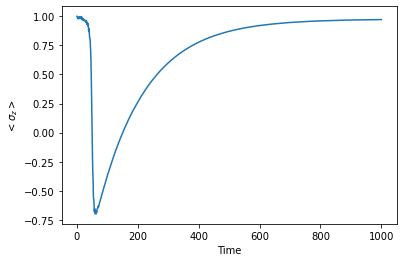

In [41]:
# Given constant parameters
omega, gamma, gamma_d = twopi, 0.001 * twopi, 0.01 * twopi

# Define time-dependent Delta
def Delta(t, args):
    if t <= 0:
        return 10 * twopi
    if t >= 100:
        return -10 * twopi
    else:
        return (10 - 0.2 * t) * twopi
    
# Solve master equation and plot the result
time = 1000
time_axis = np.linspace(0, time, 1000)
result_5b = solve_me_t(Delta, omega, gamma, gamma_d, time=time)
plt.xlabel('Time')
plt.ylabel('$<\sigma_z>$')
plt.plot(time_axis, result_5b[2])
plt.show()

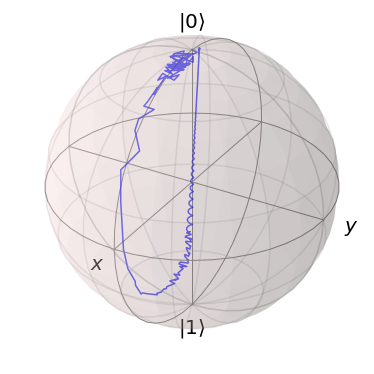

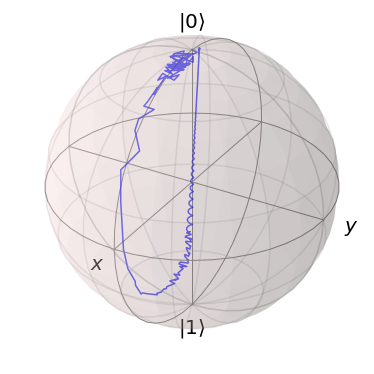

In [42]:
# Display trajectory on the Bloch sphere
bloch_sphere = Bloch()
bloch_sphere.add_points([result_5b[0], result_5b[1], result_5b[2]], meth='l')
bloch_sphere.show()